In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

In [2]:
from pygan.generativeadversarialnetworks.adversarial_auto_encoders import AdversarialAutoEncoders
from pygan.gansvaluefunction.mini_max import MiniMax

In [3]:
from pygan.generativemodel.autoencodermodel.conditional_convolutional_auto_encoder import ConditionalConvolutionalAutoEncoder as Generator
from pygan.generativemodel.conditionalgenerativemodel.conditional_convolutional_model import ConditionalConvolutionalModel
from pygan.generativemodel.deconvolution_model import DeconvolutionModel

In [4]:
from pygan.discriminativemodel.cnn_model import CNNModel as Discriminator

In [5]:
from pygan.truesampler.image_true_sampler import ImageTrueSampler
from pygan.truesampler.conditionaltruesampler.conditional_image_true_sampler import ConditionalImageTrueSampler

In [6]:
from pygan.noisesampler.image_noise_sampler import ImageNoiseSampler
from pygan.noisesampler.gauss_noise_sampler import GaussNoiseSampler

In [7]:
# First convolution layer.
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
# Second convolution layer.
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
# Computation graph in output layer.
from pydbm.synapse.cnn_output_graph import CNNOutputGraph
# Computation graph for first convolution layer.
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
# Computation graph for second convolution layer.
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# ReLu Function as activation function.
from pydbm.activation.relu_function import ReLuFunction
# SGD optimizer.
from pydbm.optimization.optparams.sgd import SGD

In [8]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pygan")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

In [9]:
batch_size = 20
width = 100
height = 100
channel = 3

image_dir = "/mnt/c/Users/木村正彬/Downloads/rgb/"
seq_len = None
gray_scale_flag = False
wh_size_tuple = (width, height)
norm_mode = "z_score"

In [10]:
true_sampler = ImageTrueSampler(
    batch_size=batch_size,
    image_dir=image_dir,
    seq_len=seq_len,
    gray_scale_flag=gray_scale_flag,
    wh_size_tuple=wh_size_tuple,
    norm_mode=norm_mode
)
conditional_image_true_sampler = ConditionalImageTrueSampler(true_sampler)

(20, 3, 100, 100)
(-3.4423555518772906, 4.5474735088646416e-18, 4.170895948987195)


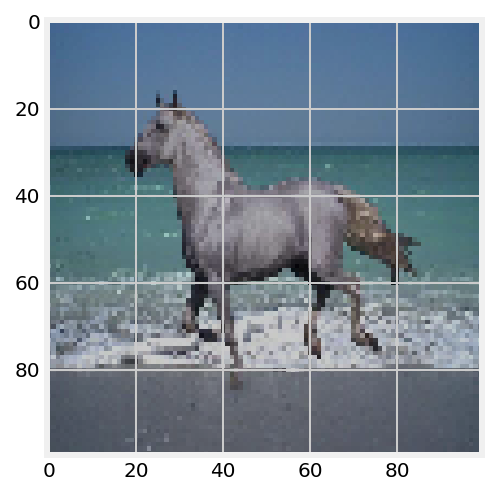

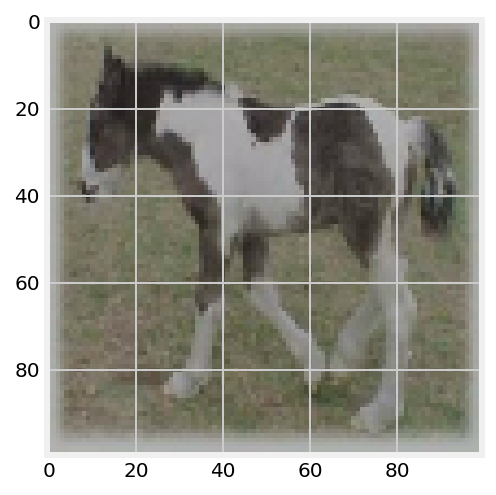

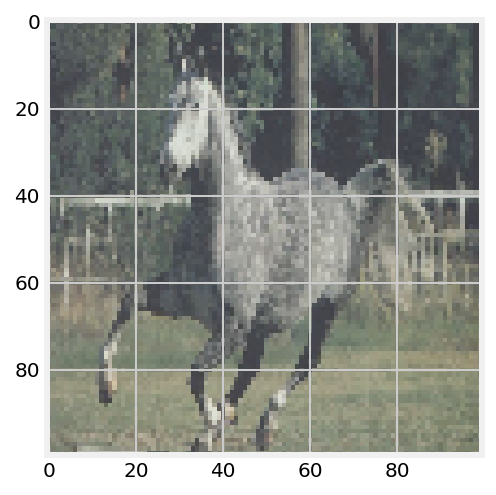

In [11]:
arr = true_sampler.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
def plot(arr):
    arr = 255 * (arr - arr.min()) / (arr.max() - arr.min())
    arr = arr.transpose(0, 2, 3, 1).astype(np.uint8)
    for i in range(3):
        plt.imshow(arr[i, :])
        plt.show()
        plt.close()
plot(arr)

In [12]:
noise_sampler = ImageNoiseSampler(
    batch_size,
    image_dir,
    seq_len=None,
    gray_scale_flag=gray_scale_flag,
    wh_size_tuple=wh_size_tuple,
    norm_mode=norm_mode
)

In [13]:
noise_sampler.generate().shape

(20, 3, 100, 100)

In [14]:
from pydbm.cnn.convolutionalneuralnetwork.convolutional_auto_encoder import ConvolutionalAutoEncoder as CAE
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2
from pydbm.activation.tanh_function import TanhFunction
from pydbm.activation.identity_function import IdentityFunction

from pydbm.activation.logistic_function import LogisticFunction
from pydbm.loss.mean_squared_error import MeanSquaredError
from pydbm.optimization.optparams.sgd import SGD
from pydbm.optimization.optparams.adam import Adam
from pydbm.cnn.layerablecnn.convolutionlayer.deconvolution_layer import DeconvolutionLayer as DeconvolutionLayer1
from pydbm.cnn.layerablecnn.convolutionlayer.deconvolution_layer import DeconvolutionLayer as DeconvolutionLayer2
from pydbm.synapse.cnn_graph import CNNGraph as DeCNNGraph1
from pydbm.synapse.cnn_graph import CNNGraph as DeCNNGraph2
from pydbm.optimization.batch_norm import BatchNorm

from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation

if gray_scale_flag is True:
    channel = 1
else:
    channel = 3
scale = 0.1

activation_function=IdentityFunction()
#activation_function.batch_norm = BatchNorm()

conv1 = ConvolutionLayer1(
    ConvGraph1(
        activation_function=activation_function,
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

conv2 = ConvolutionLayer2(
    ConvGraph2(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=batch_size,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

deconv1 = DeconvolutionLayer1(
    DeCNNGraph1(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=batch_size,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

deconv2 = DeconvolutionLayer2(
    DeCNNGraph2(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)


deconvolution_model = DeconvolutionModel(
    deconvolution_layer_list=[
        deconv1,
        deconv2
    ],
    computable_loss=MeanSquaredError(),
    cnn_output_graph=None,
    opt_params=Adam(),
    learning_rate=1e-05
)

conditional_convolutional_model = ConditionalConvolutionalModel(
    deconvolution_model,
    batch_size,
    layerable_cnn_list=[
        conv1,
        conv2
    ],
    learning_rate=1e-05,
    computable_loss=MeanSquaredError(),
    opt_params=Adam(),
    verificatable_result=VerificateFunctionApproximation(),
    condition_noise_sampler=None
)
conditional_convolutional_model.noise_sampler = noise_sampler

generator = Generator(
    conditional_convolutional_model=conditional_convolutional_model,
    batch_size=batch_size,
    learning_rate=1e-05,
)
#generator.noise_sampler = noise_sampler

(20, 3, 100, 100)
(-3.2960998029257014, -8.337034766251842e-18, 3.794412125881306)


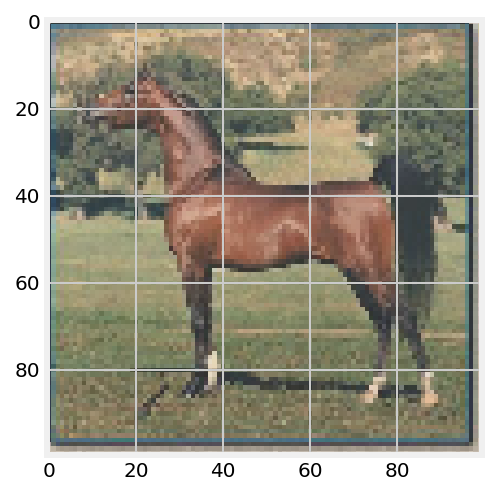

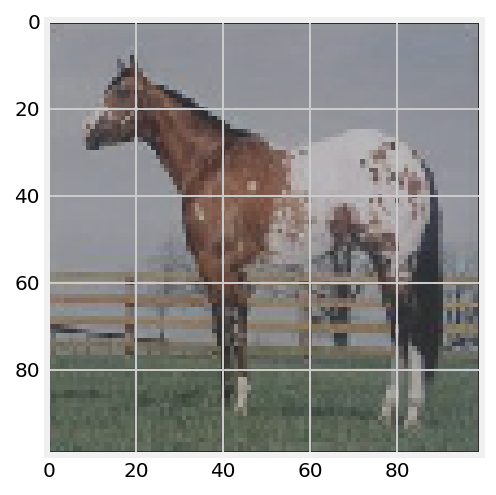

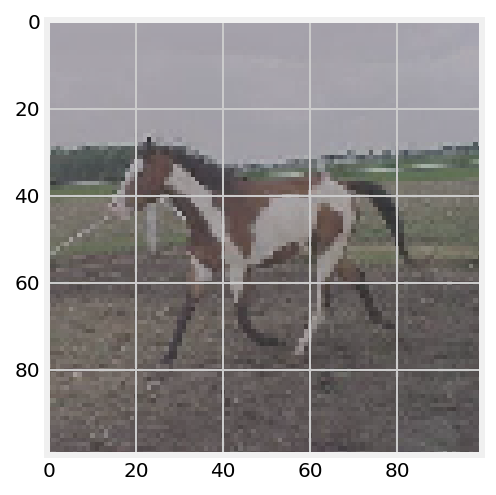

(20, 6, 100, 100)
(-4.503190559990858, 0.03330319164826979, 4.728255940246059)


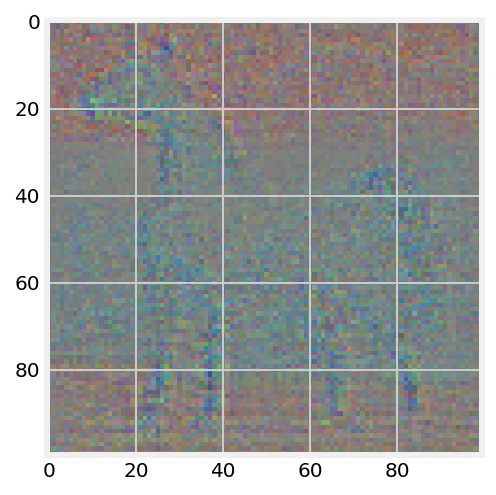

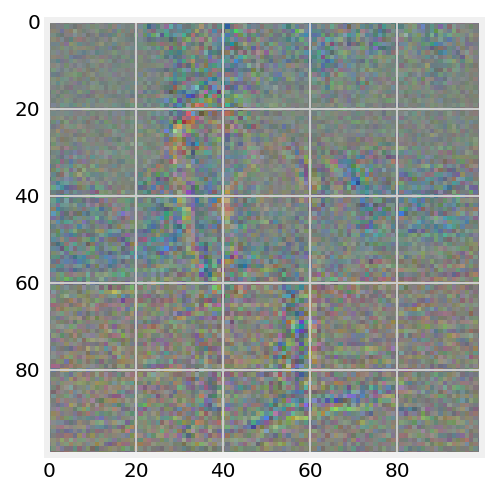

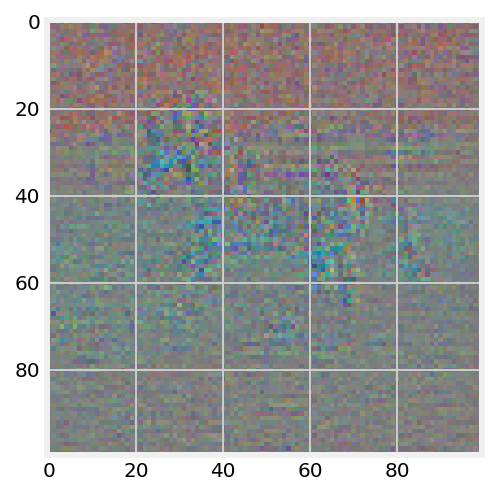

In [15]:
arr = true_sampler.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
plot(arr)

r_arr = generator.draw()
print(r_arr.shape)
print((r_arr.min(), r_arr.mean(), r_arr.max()))
plot(r_arr[:, :3])

In [16]:
generator.pre_learn(true_sampler=true_sampler, epochs=100)

Epoch: 0 loss: 0.00328380859801609
Epoch: 1 loss: 0.0032038914680434473
Epoch: 2 loss: 0.0032769534347959106
Epoch: 3 loss: 0.003173742889880196
Epoch: 4 loss: 0.0032531249224768554
Epoch: 5 loss: 0.0033378552530482475
Epoch: 6 loss: 0.0034430976786017533
Epoch: 7 loss: 0.003368516929243793
Epoch: 8 loss: 0.0033484400722158044
Epoch: 9 loss: 0.0033104397619157207
Epoch: 10 loss: 0.003323962347991095
Epoch: 11 loss: 0.0033203228771521314
Epoch: 12 loss: 0.0033759365274025053
Epoch: 13 loss: 0.0033842453744530204
Epoch: 14 loss: 0.003450113080350749
Epoch: 15 loss: 0.0034153584109607817
Epoch: 16 loss: 0.0033390675588275214
Epoch: 17 loss: 0.0033655997461171537
Epoch: 18 loss: 0.003426195536749784
Epoch: 19 loss: 0.0033302328416757124
Epoch: 20 loss: 0.003419604235113102
Epoch: 21 loss: 0.0033232786821160336
Epoch: 22 loss: 0.003330235607111727
Epoch: 23 loss: 0.0034163387715864823
Epoch: 24 loss: 0.0033762646564228487
Epoch: 25 loss: 0.0033733687641816956
Epoch: 26 loss: 0.0033889946840

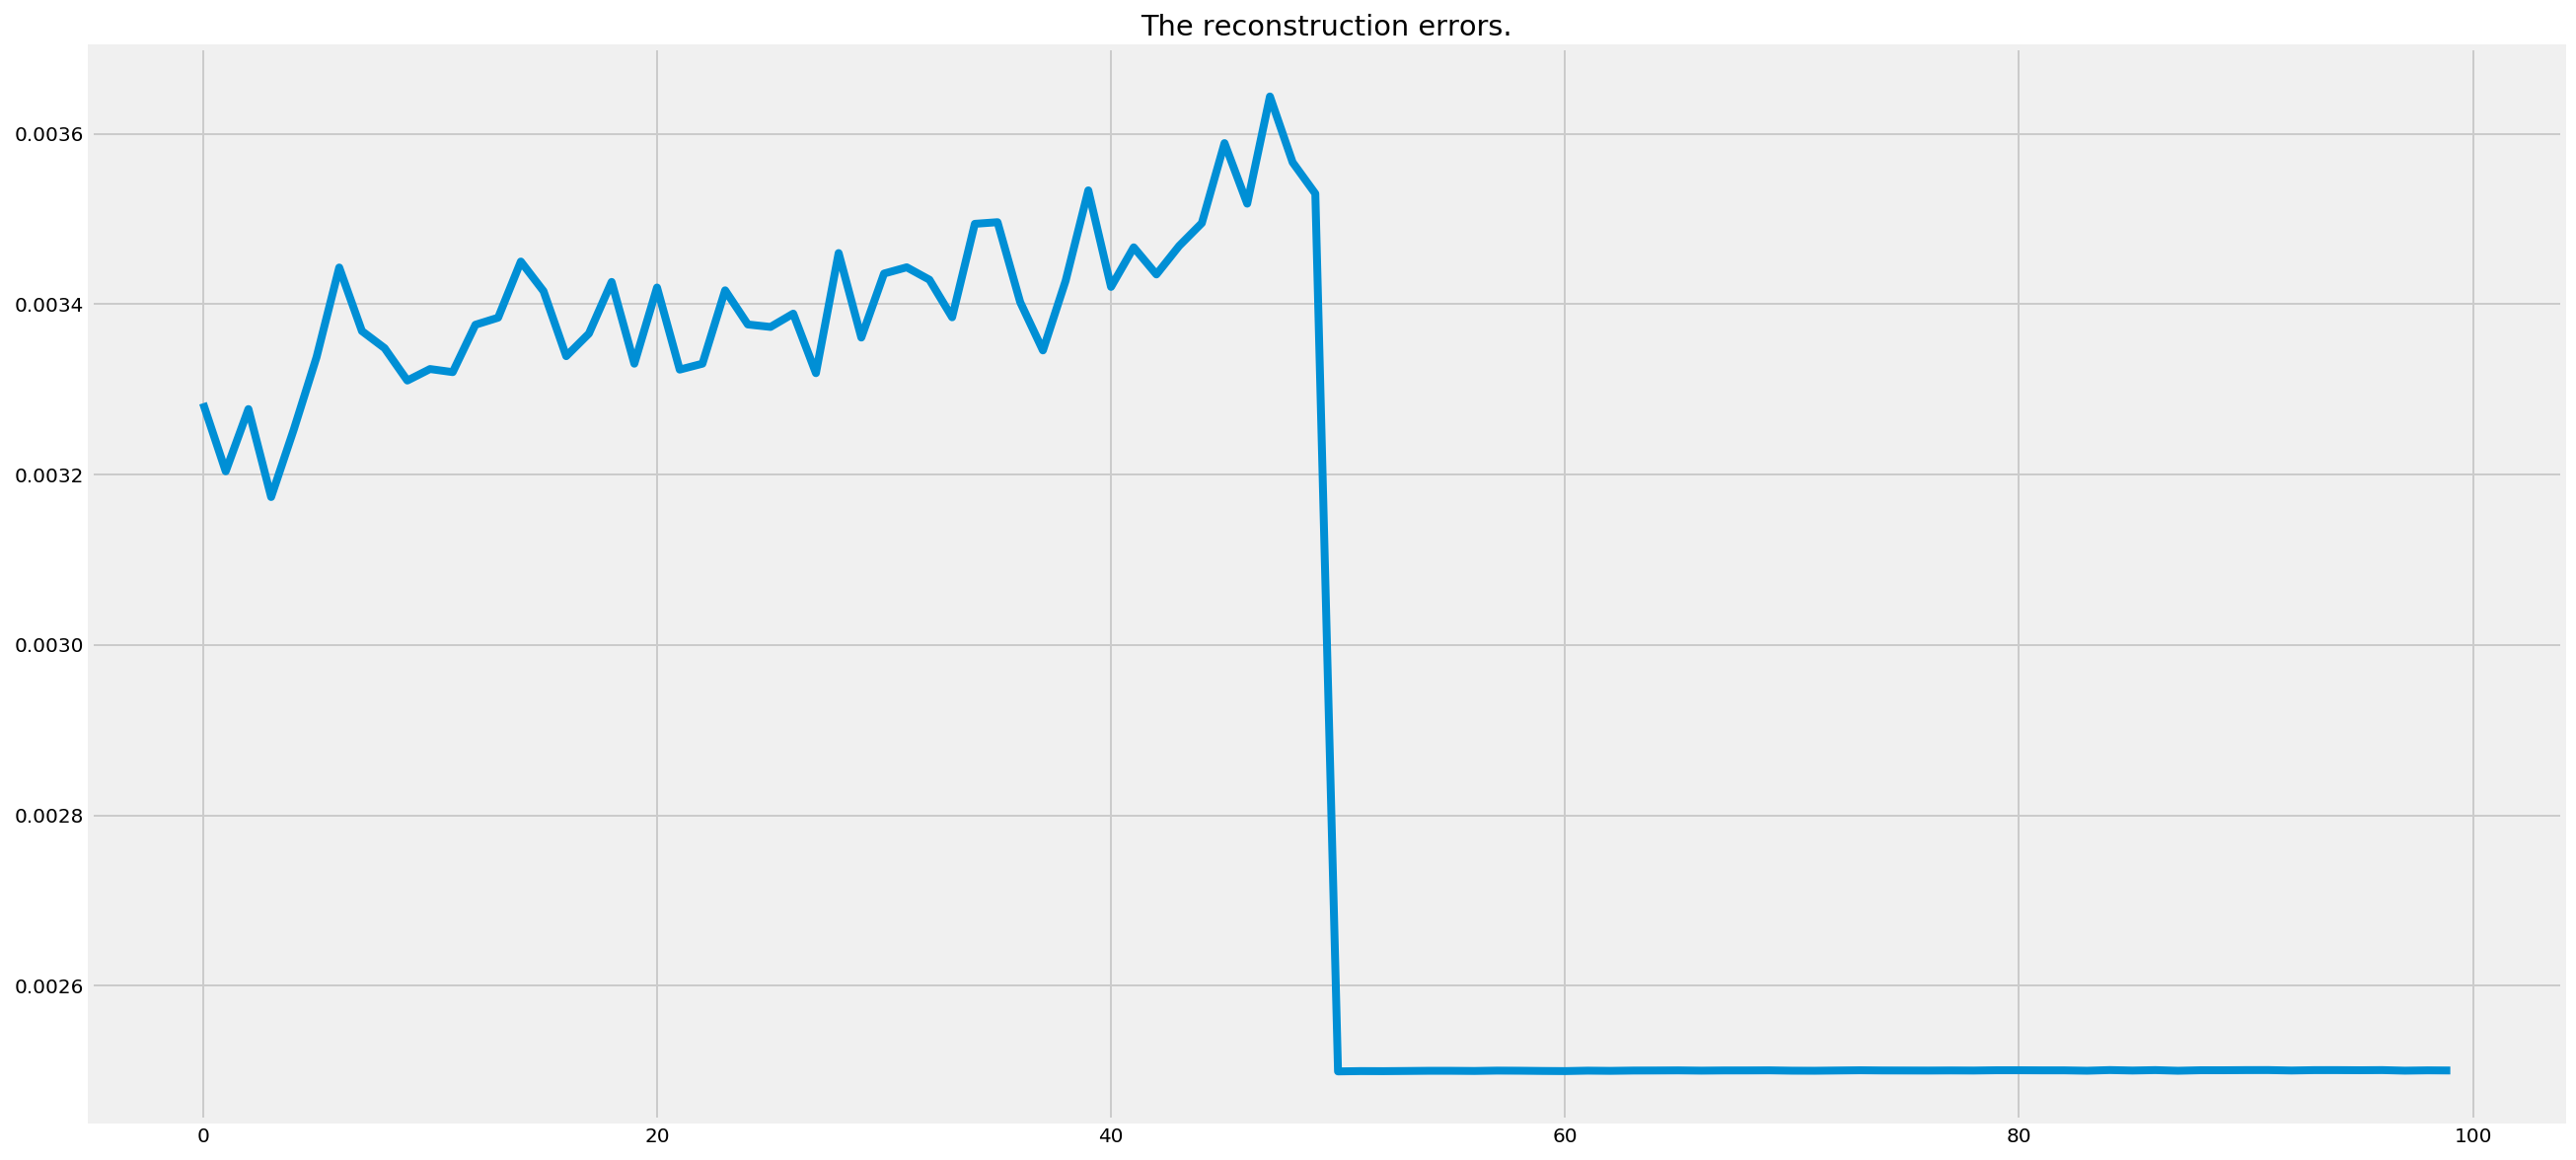

In [17]:
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(generator.pre_loss_arr)
plt.show()
plt.close()

(20, 6, 100, 100)
(-2.6492463057054505, 0.0003988984717050797, 3.6051793641411294)


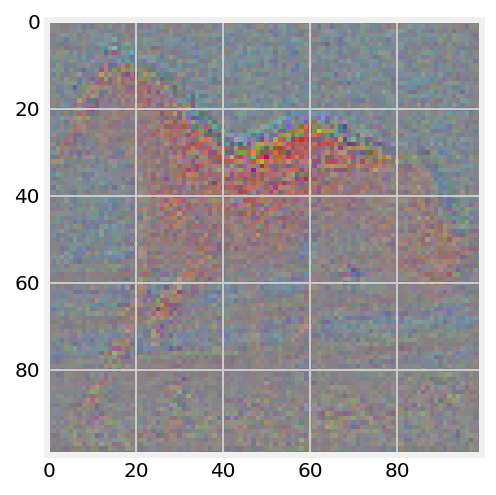

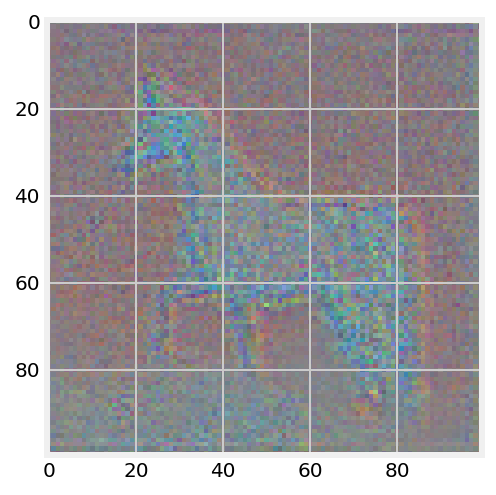

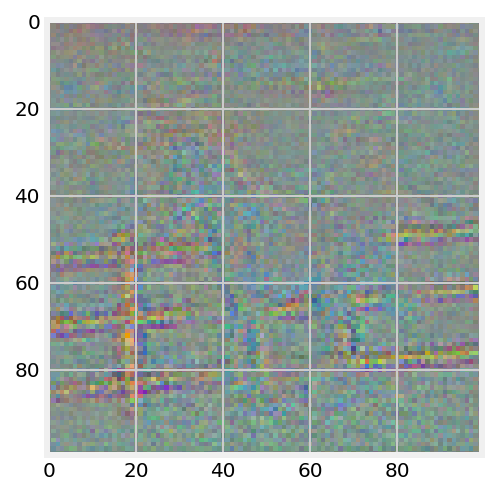

In [18]:
arr = generator.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
plot(arr[:, :3])

(20, 3, 100, 100)
(-2.829612416170915, -1.1652900866465643e-17, 4.459779881627362)


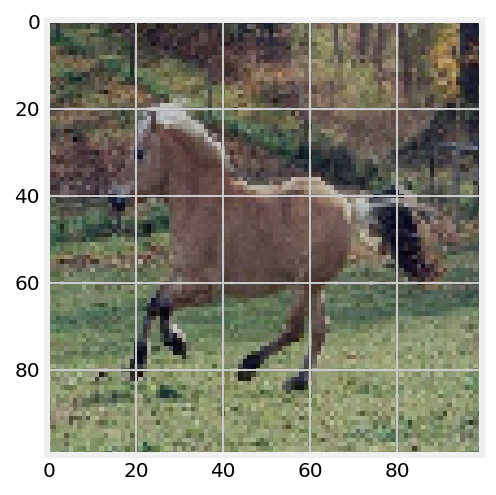

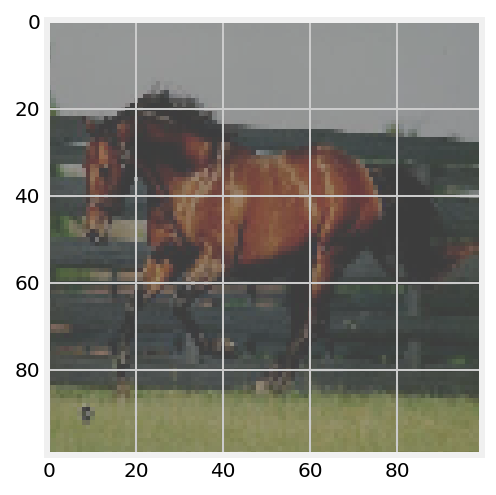

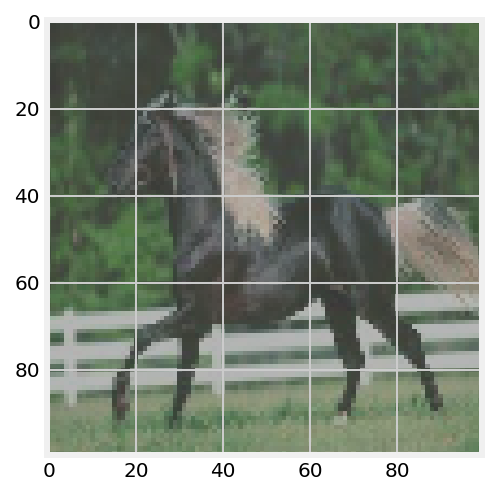

(20, 20, 100, 100)
(-0.30053008244271795, 0.00018098515557385508, 0.296280944783507)


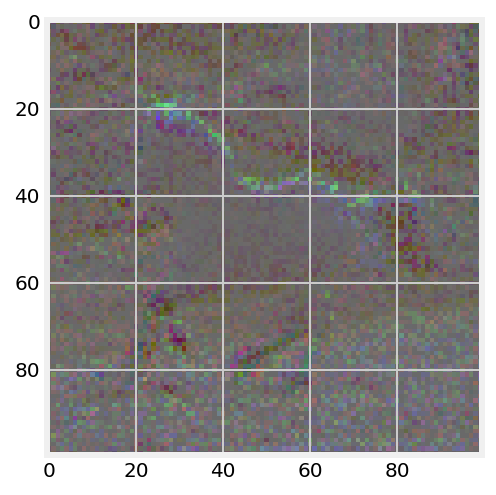

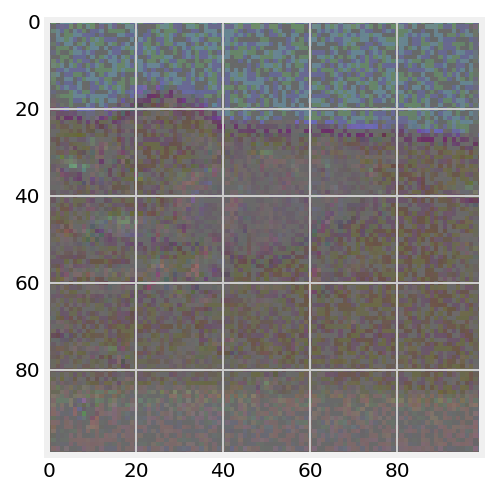

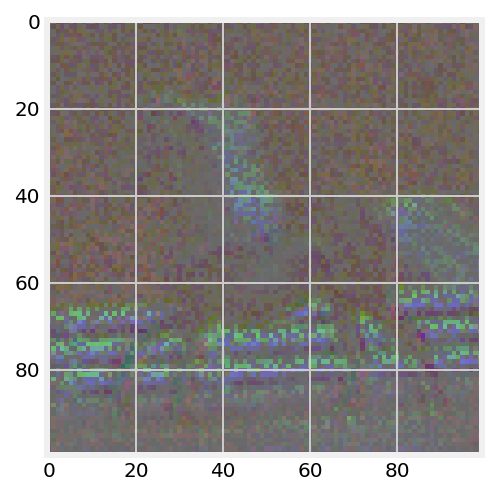

In [19]:
arr = true_sampler.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
plot(arr)

r_arr = generator.inference(arr)
print(r_arr.shape)
print((r_arr.min(), r_arr.mean(), r_arr.max()))
plot(r_arr[:, :3])

In [20]:
# First convolution layer.
conv2 = ConvolutionLayer2(
    # Computation graph for first convolution layer.
    ConvGraph2(
        # Logistic function as activation function.
        activation_function=TanhFunction(),
        # The number of `filter`.
        filter_num=batch_size,
        # The number of channel.
        channel=channel * 2,
        # The size of kernel.
        kernel_size=3,
        # The filter scale.
        scale=0.001,
        # The nubmer of stride.
        stride=3,
        # The number of zero-padding.
        pad=1
    )
)

# Stack.
layerable_cnn_list=[
    conv2
]

opt_params = Adam()
opt_params.dropout_rate = 0.0

In [21]:
scale = 0.01
cnn_output_graph = CNNOutputGraph(
    hidden_dim=23120, 
    output_dim=1, 
    activating_function=LogisticFunction(), 
    scale=scale
)

discriminator = Discriminator(
    batch_size=batch_size,
    layerable_cnn_list=layerable_cnn_list,
    cnn_output_graph=cnn_output_graph,
    learning_rate=1e-05,
    opt_params=opt_params,
)

In [22]:
from pygan.feature_matching import FeatureMatching

In [23]:
AAE = AdversarialAutoEncoders(gans_value_function=MiniMax(), feature_matching=FeatureMatching(lambda1=0.3, lambda2=0.7))

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=conditional_image_true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=1000,
    k_step=10
)

----------------------------------------------------------------------------------------------------
Iterations: (1/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002500724583723628
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.3282727390558668
And update the `discriminator` by descending its stochastic gradient(means): -2.9515093190548307
Inferenced by the `discriminator` (mean): 0.39048912707790606
And update the `discriminator` by descending its stochastic gradient(means): -3.1444923145715
Inferenced by the `discriminator` (mean): 0.5653502

Iterations: (4/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0025006760502120254
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.6192091748198769
And update the `discriminator` by descending its stochastic gradient(means): -3.85948418391042
Inferenced by the `discriminator` (mean): 0.594095024202357
And update the `discriminator` by descending its stochastic gradient(means): -4.139937443449215
Inferenced by the `discriminator` (mean): 0.589884968005595
And update the `discriminator` by descending its stochastic gradient(means): -3.7754919894140

The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0025009099364850704
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.5793621388188264
And update the `discriminator` by descending its stochastic gradient(means): -3.172900236360774
Inferenced by the `discriminator` (mean): 0.44598088870819674
And update the `discriminator` by descending its stochastic gradient(means): -3.187082299080934
Inferenced by the `discriminator` (mean): 0.39582003804868465
And update the `discriminator` by descending its stochastic gradient(means): -3.16770847671254
Inferenced by the `discriminator` (mean): 0.5388082097417776
And update the `discriminator` by descending its stoch

The reconstruction error (mean): 0.002500603607629625
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.576080446096845
And update the `discriminator` by descending its stochastic gradient(means): -3.2541691829314865
Inferenced by the `discriminator` (mean): 0.5038971210263796
And update the `discriminator` by descending its stochastic gradient(means): -3.5771122458091944
Inferenced by the `discriminator` (mean): 0.4776295107578904
And update the `discriminator` by descending its stochastic gradient(means): -3.4539788316253626
Inferenced by the `discriminator` (mean): 0.4231311380358852
And update the `discriminator` by descending its stochastic gradient(means): -3.0373599436488843
Inferenced by the `discriminator` (mean): 0.44599742675370635
And update the `discrim

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.47904325482113563
And update the `discriminator` by descending its stochastic gradient(means): -3.452447092659699
Inferenced by the `discriminator` (mean): 0.5350683501335486
And update the `discriminator` by descending its stochastic gradient(means): -3.4117845120101
Inferenced by the `discriminator` (mean): 0.4258621798943992
And update the `discriminator` by descending its stochastic gradient(means): -3.6541871289345993
Inferenced by the `discriminator` (mean): 0.5268791977768026
And update the `discriminator` by descending its stochastic gradient(means): -3.8743662842829467
Inferenced by the `discriminator` (mean): 0.5505324947123205
And update the `discriminator` by descending its stochastic gradient(means): -3.382837219070075
Inferenced by the `discriminator` (mean): 0.4889597185748059
And update the `discrimi

Inferenced by the `discriminator` (mean): 0.5669712045093431
And update the `discriminator` by descending its stochastic gradient(means): -3.363672730728793
Inferenced by the `discriminator` (mean): 0.4667749252704363
And update the `discriminator` by descending its stochastic gradient(means): -3.3372312632242624
Inferenced by the `discriminator` (mean): 0.5014128461262197
And update the `discriminator` by descending its stochastic gradient(means): -3.3666730650654992
Inferenced by the `discriminator` (mean): 0.4807866844154652
And update the `discriminator` by descending its stochastic gradient(means): -4.274555853759445
Inferenced by the `discriminator` (mean): 0.4573118308013564
And update the `discriminator` by descending its stochastic gradient(means): -3.7844365480434172
Inferenced by the `discriminator` (mean): 0.48059326658634155
And update the `discriminator` by descending its stochastic gradient(means): -3.143265422418193
Inferenced by the `discriminator` (mean): 0.5742293717

Inferenced by the `discriminator` (mean): 0.5056948419996491
And update the `discriminator` by descending its stochastic gradient(means): -3.544282140209288
Inferenced by the `discriminator` (mean): 0.5050224655841254
And update the `discriminator` by descending its stochastic gradient(means): -3.5886472793827737
Inferenced by the `discriminator` (mean): 0.47617782072812365
And update the `discriminator` by descending its stochastic gradient(means): -3.1343825865189796
Inferenced by the `discriminator` (mean): 0.48510872383402087
And update the `discriminator` by descending its stochastic gradient(means): -3.1624456306205633
Inferenced by the `discriminator` (mean): 0.5770776342800146
And update the `discriminator` by descending its stochastic gradient(means): -3.6299690592934106
Inferenced by the `discriminator` (mean): 0.6619521254858604
And update the `discriminator` by descending its stochastic gradient(means): -3.8854063003139325
Inferenced by the `discriminator` (mean): 0.5159948

Inferenced by the `discriminator` (mean): 0.5760183123182504
And update the `discriminator` by descending its stochastic gradient(means): -3.385361790187292
Inferenced by the `discriminator` (mean): 0.531194627202827
And update the `discriminator` by descending its stochastic gradient(means): -3.6638131927951187
Inferenced by the `discriminator` (mean): 0.55593892275908
And update the `discriminator` by descending its stochastic gradient(means): -4.4067634632929895
Inferenced by the `discriminator` (mean): 0.5696823197335156
And update the `discriminator` by descending its stochastic gradient(means): -3.630125972199712
Inferenced by the `discriminator` (mean): 0.3799609290827418
And update the `discriminator` by descending its stochastic gradient(means): -3.3212252789524457
Inferenced by the `discriminator` (mean): 0.47152148604866034
And update the `discriminator` by descending its stochastic gradient(means): -3.199650748759355
Inferenced by the `discriminator` (mean): 0.5597759627904

Inferenced by the `discriminator` (mean): 0.3540568322940027
And update the `discriminator` by descending its stochastic gradient(means): -3.348665978956378
Inferenced by the `discriminator` (mean): 0.5218044025320021
And update the `discriminator` by descending its stochastic gradient(means): -3.6157244230971948
Inferenced by the `discriminator` (mean): 0.5682923507305293
And update the `discriminator` by descending its stochastic gradient(means): -3.700309359846939
Inferenced by the `discriminator` (mean): 0.3622233117280702
And update the `discriminator` by descending its stochastic gradient(means): -3.156184361399824
Inferenced by the `discriminator` (mean): 0.46392557495810066
And update the `discriminator` by descending its stochastic gradient(means): -3.621893031332801
Inferenced by the `discriminator` (mean): 0.42008806356795014
And update the `discriminator` by descending its stochastic gradient(means): -3.4653371963555637
Inferenced by the `discriminator` (mean): 0.4575341411

Inferenced by the `discriminator` (mean): 0.632837889625742
And update the `discriminator` by descending its stochastic gradient(means): -3.849560896164126
Inferenced by the `discriminator` (mean): 0.5743776794151337
And update the `discriminator` by descending its stochastic gradient(means): -3.3161193719654585
Inferenced by the `discriminator` (mean): 0.442770583072518
And update the `discriminator` by descending its stochastic gradient(means): -3.3932901792801387
Inferenced by the `discriminator` (mean): 0.4822546451686832
And update the `discriminator` by descending its stochastic gradient(means): -3.125756827359682
Inferenced by the `discriminator` (mean): 0.5310771057233638
And update the `discriminator` by descending its stochastic gradient(means): -3.072729287906822
Inferenced by the `discriminator` (mean): 0.5487480262520552
And update the `discriminator` by descending its stochastic gradient(means): -3.534758624254276
----------------------------------------------------------

Inferenced by the `discriminator` (mean): 0.4973600334398399
And update the `discriminator` by descending its stochastic gradient(means): -4.0824601089434545
Inferenced by the `discriminator` (mean): 0.3692024235670935
And update the `discriminator` by descending its stochastic gradient(means): -2.7203595938673866
Inferenced by the `discriminator` (mean): 0.5294458876070869
And update the `discriminator` by descending its stochastic gradient(means): -3.5508394916288273
Inferenced by the `discriminator` (mean): 0.4495026778124891
And update the `discriminator` by descending its stochastic gradient(means): -3.368004938471775
Inferenced by the `discriminator` (mean): 0.6155459847567103
And update the `discriminator` by descending its stochastic gradient(means): -3.9904192528020714
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
--------------------------------------------------------------------------------------

Inferenced by the `discriminator` (mean): 0.5631962733506015
And update the `discriminator` by descending its stochastic gradient(means): -3.3618521017357197
Inferenced by the `discriminator` (mean): 0.477828879812712
And update the `discriminator` by descending its stochastic gradient(means): -3.328073453685577
Inferenced by the `discriminator` (mean): 0.5262580471040139
And update the `discriminator` by descending its stochastic gradient(means): -3.3600319218626793
Inferenced by the `discriminator` (mean): 0.3397447100166381
And update the `discriminator` by descending its stochastic gradient(means): -3.068588053489921
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024934772122913672
Inferenced by the `discriminator` (mean): 0.5192419144097753
Inferenced by the `discriminator` (M

Inferenced by the `discriminator` (mean): 0.5958043660504948
And update the `discriminator` by descending its stochastic gradient(means): -3.90135959928233
Inferenced by the `discriminator` (mean): 0.4629415156239352
And update the `discriminator` by descending its stochastic gradient(means): -3.0670073504861706
Inferenced by the `discriminator` (mean): 0.5169269108060942
And update the `discriminator` by descending its stochastic gradient(means): -3.453788540219525
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024644801105101473
Inferenced by the `discriminator` (mean): 0.5778609068415339
Inferenced by the `discriminator` (MAE): 0.5778609068415339
And update the `generator` by descending its stochastic gradient(means): 1.3924639155826763e-05
--------------------------------------

Inferenced by the `discriminator` (mean): 0.6000360122319892
And update the `discriminator` by descending its stochastic gradient(means): -3.6305134606531766
Inferenced by the `discriminator` (mean): 0.48264209929188856
And update the `discriminator` by descending its stochastic gradient(means): -3.8073510526644725
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0025239394692660026
Inferenced by the `discriminator` (mean): 0.5663579873748475
Inferenced by the `discriminator` (MAE): 0.5663579873748475
And update the `generator` by descending its stochastic gradient(means): 1.2500832488935237e-05
----------------------------------------------------------------------------------------------------
Iterations: (41/1000)
---------------------------------------------------------------------

Inferenced by the `discriminator` (mean): 0.5566271498707841
And update the `discriminator` by descending its stochastic gradient(means): -3.1814246523907648
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002418766319037585
Inferenced by the `discriminator` (mean): 0.487564104796584
Inferenced by the `discriminator` (MAE): 0.487564104796584
And update the `generator` by descending its stochastic gradient(means): 1.2044617417591053e-05
----------------------------------------------------------------------------------------------------
Iterations: (44/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
Th

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024266019096576574
Inferenced by the `discriminator` (mean): 0.6010613549491447
Inferenced by the `discriminator` (MAE): 0.6010613549491447
And update the `generator` by descending its stochastic gradient(means): 1.3022063950248229e-05
----------------------------------------------------------------------------------------------------
Iterations: (47/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0025013644134096297
----------------------------------------------------------------------------------------------------
T

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024130850887767634
Inferenced by the `discriminator` (mean): 0.3927599144576047
Inferenced by the `discriminator` (MAE): 0.3927599144576047
And update the `generator` by descending its stochastic gradient(means): 1.1313528267918282e-05
----------------------------------------------------------------------------------------------------
Iterations: (50/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0025007962655550584
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
--------------------------------------------------------------------------

Loss of Feature matching: 0.0025296332168469036
Inferenced by the `discriminator` (mean): 0.6068543504726002
Inferenced by the `discriminator` (MAE): 0.6068543504726002
And update the `generator` by descending its stochastic gradient(means): 1.2053078146050885e-05
----------------------------------------------------------------------------------------------------
Iterations: (53/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0025011799211969747
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.47687223995472944
And update the `discriminator` by de

Inferenced by the `discriminator` (MAE): 0.5096910871288188
And update the `generator` by descending its stochastic gradient(means): 1.1783407021545991e-05
----------------------------------------------------------------------------------------------------
Iterations: (56/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002501122592795376
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.636220729527945
And update the `discriminator` by descending its stochastic gradient(means): -3.683008701947928
Inferenced by the `discriminator` (mean): 0.39448492

----------------------------------------------------------------------------------------------------
Iterations: (59/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0025009977275814543
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.501501488077041
And update the `discriminator` by descending its stochastic gradient(means): -3.285960892454213
Inferenced by the `discriminator` (mean): 0.48440168718651855
And update the `discriminator` by descending its stochastic gradient(means): -3.528448746701204
Inferenced by the `discriminator` (mean): 0.47500

Iterations: (62/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002501132624743856
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.4186965004546342
And update the `discriminator` by descending its stochastic gradient(means): -3.148751027742473
Inferenced by the `discriminator` (mean): 0.4895998606685086
And update the `discriminator` by descending its stochastic gradient(means): -3.6613288406649906
Inferenced by the `discriminator` (mean): 0.45031312260307005
And update the `discriminator` by descending its stochastic gradient(means): -3.37478451

The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002501121753192052
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.43833980449718757
And update the `discriminator` by descending its stochastic gradient(means): -3.760340907068899
Inferenced by the `discriminator` (mean): 0.40504334473368575
And update the `discriminator` by descending its stochastic gradient(means): -2.989926076561227
Inferenced by the `discriminator` (mean): 0.47338065036114296
And update the `discriminator` by descending its stochastic gradient(means): -3.3642066252583205
Inferenced by the `discriminator` (mean): 0.4189653615866587
And update the `discriminator` by descending its sto

In [ ]:
a_logs_list, d_logs_list, g_logs_list = AAE.extract_logs_tuple()

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Losses of feature matching.")
plt.plot(AAE.feature_matching.loss_arr)
plt.show()
plt.close()

In [ ]:
arr = true_sampler.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
plot(arr)

r_arr = generator.inference(arr)
print(r_arr.shape)
print((r_arr.min(), r_arr.mean(), r_arr.max()))
plot(r_arr)

In [ ]:
arr2 = generator.draw()
plot(arr2)

In [ ]:
observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(arr2)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=100,
    k_step=10
)

In [ ]:
a_logs_list2, d_logs_list2, g_logs_list2 = AAE.extract_logs_tuple()
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list2)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list2)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list2)
plt.show()
plt.close()

In [ ]:
arr3 = generator.draw()
plot(arr3)

In [ ]:
observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=500,
    k_step=10
)

In [ ]:
a = list()
a.extend(a_logs_list)
a.extend(a_logs_list2)
a.extend(a_logs_list3)
a.extend(a_logs_list4)

plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a)
plt.show()
plt.close()

In [ ]:
a_logs_list3, d_logs_list3, g_logs_list3 = AAE.extract_logs_tuple()
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list3)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list3)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list3)
plt.show()
plt.close()

In [ ]:
arr4 = generator.draw()
plot(arr4)

In [ ]:
observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=500,
    k_step=10
)

a_logs_list4, d_logs_list4, g_logs_list4 = AAE.extract_logs_tuple()
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list4)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list4)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list4)
plt.show()
plt.close()

arr5 = generator.draw()
plot(arr5)

observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=2000,
    k_step=5
)

a_logs_list5, d_logs_list5, g_logs_list5 = AAE.extract_logs_tuple()
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list5)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list5)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list5)
plt.show()
plt.close()

arr5 = generator.draw()
plot(arr5)

observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=2000,
    k_step=5
)

a_logs_list6, d_logs_list6, g_logs_list6 = AAE.extract_logs_tuple()
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list6)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list6)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list6)
plt.show()
plt.close()

arr6 = generator.draw()
plot(arr6)

observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [ ]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=2000,
    k_step=5
)

a_logs_list7, d_logs_list7, g_logs_list7 = AAE.extract_logs_tuple()
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list7)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list7)
plt.show()
plt.close()
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list7)
plt.show()
plt.close()

arr7 = generator.draw()
plot(arr7)

observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)